In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from scipy.signal import welch
import scipy.special
from scipy.special import erfc
import math
from math import log, log2, sqrt
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, interactive, Layout, Dropdown, IntText, HBox, VBox, Output
from IPython.display import display, clear_output
import time
print("Libraries added successfully!")

Libraries added successfully!


C:\Users\lampr\AppData\Local\Temp\ipykernel_24172\1001522890.py:165: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  r=int(np.binary_repr(j, width=bps))


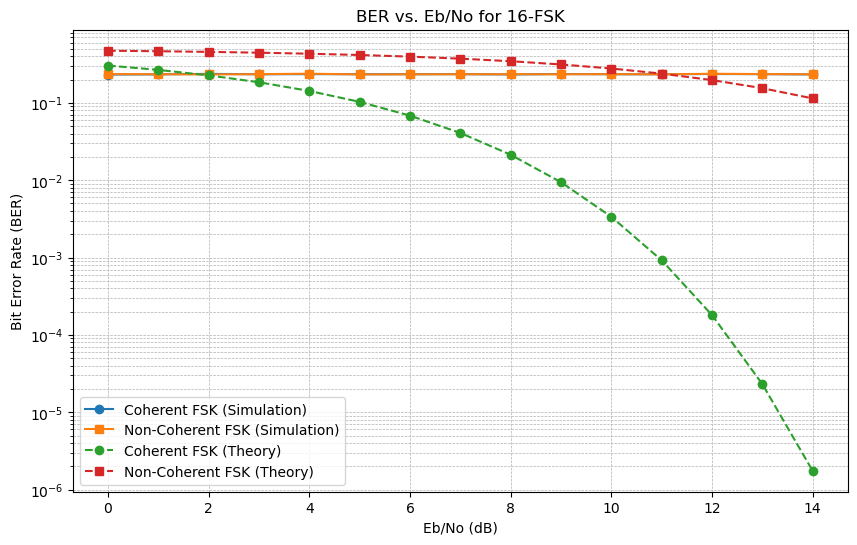

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def bin2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y

def method(byte,bps):
    arr = []
    for i in range(bps, 0, -1):
        arr.append((byte & 1<<i)>>i)
    return arr

def maxInd(p):
    b=max(p)
    k=0
    
    for h in range(0,len(p)):
        if (p[h]==b):
            k=h
    
    
    return k

def bi2de(test_list):
    res = 0
    for ele in test_list: 
        res = (res << 1) | ele    
    return res 

def addAWGN(x, SNR_dB):
    
    L=len(x)
    SNR = np.power(10,(SNR_dB/10)) #SNR to linear scale
    Esym=np.sum(abs(x)*abs(x))/L  #Calculate actual symbol energy
    
      
   
    N0=Esym/SNR #Find the noise spectral density
    
    noiseSigma =math.sqrt(N0)#Standard deviation for AWGN Noise when x is real
    n = noiseSigma*np.random.randn(1,L) #computed noise
       
    y = x + n  #received signal    
    return y
    
#Simulation of errors in MFSK 
def fsk_errors(coherence,bps,Nsymb,nsamp,EbNo):
    #coherence=True   
    #bps=4
    #Nsymb=2000
    #nsamp=16
    #EbNo=5
        #Input Parameters
        # bps:      bits per symbol
        # Nsymb:    number of symbols to be simulated
        # nsamp:    number of samples per symbol (oversampling)
        # EbNo:     normalized signal-to-noise ratio (in dB)
    M=np.power(2,bps) #Number of different symbols (modulation order)
    BR=1              #Baud Rate
    fc=2*M*BR         #RF Frequency 
        #nbits=bps*Nsymb  number of simulated data bits

    T=1/BR     #one symbol perio
    Ts=1/nsamp # oversampling period
    Fs=1/Ts  #sampling frequency 
    k=np.arange(1,M+1)
    f=fc +BR*(k-(M+1)/2) # M frequencies in "non-coherent" distance (BR)
    SNR = EbNo + 10*np.log10(bps) - 10*np.log10(nsamp/2) # AWGN channel noise (in dB)
    
    x = np.transpose(np.random.randint(2, size=(bps,Nsymb)))     # Random binary data stream of (bps)x(Nsymb) bits
    y = [bin2int(z[::-1]) for z in x]  #Sequence of symbols to be sent
    tks = np.arange(0,1,Ts)
    tks=np.transpose(tks)




        # Sender: FSK signal
    s=np.zeros((1,len(tks)*Nsymb+1))
        #Create properly (f(i)) frequency modulated signal
    for k in range(0,len(x[:, 1])):
          # len(x[:, 1]) == Nsymb
            index=bi2de(x[k,:]) 
            #print(index)
            fk=f[index]
            tk = k*T + tks
            r= k*len(tk) + np.arange(1,len(tk)+1)
                                   #print(r)
            if coherence:
                th = 0
            else:
                th = 2*np.pi*np.random.uniform(0,1,1)


            s[0,r]=np.sin(2*np.pi*fk*tk + th)





    #print(s)
    #freq, Pxx_den =signal.welch(s,Fs)
    #Pxx_den=np.transpose(Pxx_den)
    #plt.figure(figsize=(13,15))
    #plt.semilogy(freq, Pxx_den)
    #plt.ylim([0.5e-3, 1])
    #plt.xlabel('frequency [Hz]')
    #plt.ylabel('PSD [V**2/Hz]')
    #plt.grid()
    #plt.show()
    #figure(1); welch(s, [], [], [], Fs/Td);


    # Channel: Noise addition to the bandpass signal
    snoisy = addAWGN(s,SNR)
    
    #freq, Pxx_den =signal.welch(snoisy,Fs)
    # Pxx_den=np.transpose(Pxx_den)
    #plt.figure(figsize=(13,15))
    #plt.semilogy(freq, Pxx_den)


    #plt.ylim([0.5e-3, 1])
    #plt.xlabel('frequency [Hz]')
    #plt.ylabel('PSD with Gaussian Noise [V**2/Hz]')
    #plt.grid()
    
    #plt.show()


      #figure(2); welch(snoisy, [], [], [], Fs/Td);




    # Receiver: FSK signal
    xr=np.zeros((int(len(tks)*Nsymb/nsamp),bps))

    for k in range(1,int(len(tks)*Nsymb/nsamp)): #len(snoisy)/nsamp == Nsymb
            tk = k*T + tks

            sk = np.take(snoisy, range((k-1)*nsamp, k*nsamp)) 
            smi = []
            #Coherent demodulation MLE
            if coherence:
                for i in range(0,M):
                    si=np.sin(2*np.pi*f[i]*tk)

                    smi[0:]=sum([np.multiply(sk,si)])


            # Non-coherent demodulation MLE
            else:
                for i in range(1,M):
                    si=np.sin(2*np.pi*f[i]*tk)
                    sq=np.cos(2*np.pi*f[i]*tk)
                    smi[0:]=np.power(np.power(sum([np.multiply(sk,si)]),2)+np.power(sum([np.multiply(sk,sq)]),2),0.5)

            p=np.transpose(smi)
            j=maxInd(p)
            r=int(np.binary_repr(j, width=bps))


            xr[k:] = method(r,bps) # convert in demodulation to binary 

    errors=0
    #print(xr.shape)
    for i in range(0,int(len(tks)*Nsymb/nsamp)):
        p=0
        for j in range(0,bps):
            if (x[i,j]==xr[i,j]):
                 p=p+1
        if(p!=bps):
            errors=errors+1
            
        
    

    return errors, s, snoisy


def theoretical_ber_coherent(M, EbNo):
    return 0.5 * np.exp(-EbNo / 2)

def theoretical_ber_non_coherent(M, EbNo):
    return 0.5 * np.exp(-EbNo / (M + 1))

# Simulation parameters
bps = 4  # for 16-FSK
Nsymb = 2000  # Reduced number of symbols to be simulated
nsamp = 128
EbNo_dB_range = np.arange(0, 15, 1)  # Reduced number of points

ber_coherent_sim = []
ber_non_coherent_sim = []
ber_coherent_theory = []
ber_non_coherent_theory = []

for EbNo_dB in EbNo_dB_range:
    errors_coherent, s_coherent, snoisy_coherent = fsk_errors(True, bps, Nsymb, nsamp, EbNo_dB)
    errors_non_coherent, s_non_coherent, snoisy_non_coherent = fsk_errors(False, bps, Nsymb, nsamp, EbNo_dB)
    
    ber_coherent_sim.append(errors_coherent / (Nsymb * bps))
    ber_non_coherent_sim.append(errors_non_coherent / (Nsymb * bps))
    
    EbNo = 10 ** (EbNo_dB / 10)
    ber_coherent_theory.append(theoretical_ber_coherent(16, EbNo))
    ber_non_coherent_theory.append(theoretical_ber_non_coherent(16, EbNo))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_dB_range, ber_coherent_sim, 'o-', label='Coherent FSK (Simulation)')
plt.semilogy(EbNo_dB_range, ber_non_coherent_sim, 's-', label='Non-Coherent FSK (Simulation)')
plt.semilogy(EbNo_dB_range, ber_coherent_theory, 'o--', label='Coherent FSK (Theory)')
plt.semilogy(EbNo_dB_range, ber_non_coherent_theory, 's--', label='Non-Coherent FSK (Theory)')

plt.xlabel('Eb/No (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs. Eb/No for 16-FSK')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

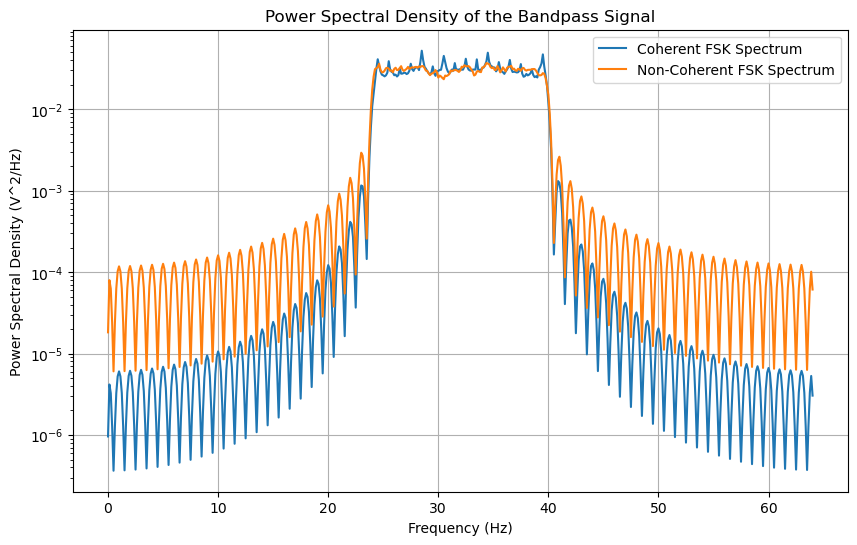

In [3]:
Ts = 1 / nsamp  # oversampling period
Fs = 1 / Ts  # sampling frequency

# Plotting the spectrum of the bandpass signal
f_coherent, Pxx_coherent = welch(s_coherent.flatten(), Fs, nperseg=1024)
f_non_coherent, Pxx_non_coherent = welch(s_non_coherent.flatten(), Fs, nperseg=1024)

plt.figure(figsize=(10, 6))
plt.semilogy(f_coherent, Pxx_coherent, label='Coherent FSK Spectrum')
plt.semilogy(f_non_coherent, Pxx_non_coherent, label='Non-Coherent FSK Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('Power Spectral Density of the Bandpass Signal')
plt.grid(True)
plt.legend()
plt.show()